In [1]:
import gym
import numpy as np
import time
from IPython import display
import or_gym
from value_iteration import *
from policy_iteration import *

In [2]:
env_name = 'NewsVendorDiscrete-v0'
env = or_gym.make(
    env_name, 
    max_inventory = 20, 
    max_order_quantity = 10,
    step_limit= 100,
    p_max= 5,    # Max sale price,
    h_max= 10,     # Max holding cost,
    k_max= 3,    # Max lost sales penalty,
    mu_max= 10 
)

In [3]:
print(env.action_space)
print(env.observation_space)
print(env.price)
print(env.cost)
print(env.h)
# print(env.k)
print(env.mu)
env.P[env.mu]

Discrete(10)
Discrete(20)
3.4068974625699147
1.1074385145395198
0.5675399213001111
7


{0: [(1, 0, 23.8482822379894, 0)],
 1: [(1, 1, 22.74084372344988, 0)],
 2: [(1, 2, 21.63340520891036, 0)],
 3: [(1, 3, 20.525966694370844, 0)],
 4: [(1, 4, 19.418528179831323, 0)],
 5: [(1, 5, 18.311089665291803, 0)],
 6: [(1, 6, 17.203651150752282, 0)],
 7: [(1, 7, 16.096212636212762, 0)],
 8: [(1, 8, 14.988774121673243, 0)],
 9: [(1, 9, 13.881335607133723, 0)]}

In [4]:
env.P[env.mu + 5]

{0: [(1, 5, 21.010582631488845, 0)],
 1: [(1, 6, 19.903144116949328, 0)],
 2: [(1, 7, 18.795705602409804, 0)],
 3: [(1, 8, 17.688267087870287, 0)],
 4: [(1, 9, 16.58082857333077, 0)],
 5: [(1, 10, 15.473390058791248, 0)],
 6: [(1, 11, 14.365951544251727, 0)],
 7: [(1, 12, 13.258513029712207, 0)],
 8: [(1, 13, 12.151074515172688, 0)],
 9: [(1, 14, 11.043636000633168, 0)]}

In [5]:
env.observation_space.n

20

In [6]:
env.action_space.n

10

## Value Iteration

In [14]:
v_values = value_iteration(env, max_iters=1000, gamma=0.9, theta=0.1)
v_values

Converged at 48-th iteration.


array([ 77.7072518 ,  96.2439515 , 111.11207637, 125.98020123,
       136.77213182, 147.56406241, 153.82688826, 160.0897141 ,
       160.6296127 , 161.16951129, 161.70940988, 162.24930848,
       162.78920707, 163.32910566, 163.86900426, 163.78737307,
       163.70574188, 163.62411069, 163.54247951, 163.46084832])

In [8]:
value_iter_policy = policy_extraction(env, v_values, gamma=1)
value_iter_policy

array([9, 9, 9, 9, 9, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0])

In [9]:
from play import *

In [10]:
print(play(env, value_iter_policy))
play_multiple_times(env, value_iter_policy, 1000)

-239.05508345549487
Avr reward: -360.86341300766


## Policy Iteration

In [15]:
policy_iter_policy = policy_iteration(env, max_iters=1000, gamma=0.9, theta=0.1)
policy_iter_policy

Converged at 2-th iteration.


array([9, 9, 9, 9, 9, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0])

In [12]:
print(play(env, policy_iter_policy))
play_multiple_times(env, policy_iter_policy, 1000)

-335.4992368812276
Avr reward: -357.9241465740346


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(policy_iter_policy, value_iter_policy)

In [32]:
demands = range(5, 16, 2)
env_name = 'NewsVendorDiscrete-v0'
policies = []
for demand in demands:
    env = or_gym.make(
        env_name, 
        max_inventory = 20, 
        max_order_quantity = 10,
        step_limit= 100,
        p_max= 10,    # Max sale price,
        h_max= 3,     # Max holding cost,
        k_max= 3,    # Max lost sales penalty,
        mu_max= demand 
    )
    policy_iter_policy = policy_iteration(env, max_iters=1000, gamma=0.9, theta=0.01)
    policies.append(policy_iter_policy)

Converged at 2-th iteration.
Converged at 2-th iteration.
Converged at 2-th iteration.
Converged at 3-th iteration.
Converged at 3-th iteration.
Converged at 3-th iteration.


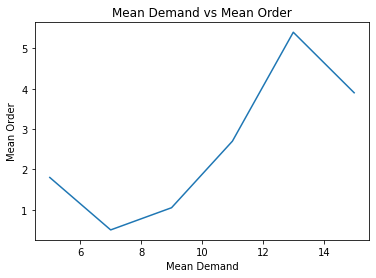

In [34]:
import matplotlib.pyplot as plt
plt.plot(demands, [np.mean(policy) for policy in policies])
plt.title('Mean Demand vs Mean Order')
plt.xlabel('Mean Demand')
plt.ylabel('Mean Order')
plt.show()

In [ ]:
lost_sales = range(20)
env_name = 'NewsVendorDiscrete-v0'
policies = []
for lost_sale in lost_sales:
    env = or_gym.make(
        env_name, 
        max_inventory = 20, 
        max_order_quantity = 10,
        step_limit= 100,
        p_max= 10,    # Max sale price,
        h_max= 3,     # Max holding cost,
        k_max= lost_sale,    # Max lost sales penalty,
        mu_max= 10 
    )
    policy_iter_policy = policy_iteration(env, max_iters=1000, gamma=0.9, theta=0.01)
    policies.append(policy_iter_policy)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(demands, [np.mean(policy) for policy in policies])
plt.title('Mean Demand vs Mean Order')
plt.xlabel('Mean Demand')
plt.ylabel('Mean Order')
plt.show()

## PPO

In [1]:
import or_gym
from or_gym.utils import create_env
import ray
import ray.rllib.agents.ppo as ppo
from ray import tune
from ppo import *

def register_env(env_name, env_config={}):
    env = create_env(env_name)
    tune.register_env(env_name, 
        lambda env_name: env(env_name,
            env_config=env_config))

In [2]:
env_name = 'NewsVendorDiscrete-v0'
# env = or_gym.make(
#     env_name, 
#     max_inventory = 20, 
#     max_order_quantity = 10,
#     step_limit= 100,
#     p_max= 5,    # Max sale price,
#     h_max= 10,     # Max holding cost,
#     k_max= 3,    # Max lost sales penalty,
#     mu_max= 10 
# )

# Environment and RL Configuration Settings
env_config = {        
    # 'lead_time': 10,
    'max_inventory': 20,
    'max_order_quantity': 10,
    'step_limit': 100,
    'p_max': 5,    # Max sale price,
    'h_max': 10 ,     # Max holding cost,
    'k_max': 3 ,    # Max lost sales penalty,
    'mu_max': 10  , # Max mean of the demand distribution,
}

# Register environment
register_env(env_name, env_config)

rl_config['env'] = env_name
rl_config['env_config'] = env_config

In [3]:
agent = ppo.PPOTrainer(env=env_name,
    config=rl_config)
 
results = []
for i in range(200):
    res = agent.train()
    results.append(res)
    if (i+1) % 5 == 0:
        print('\nIter: {}\tReward: {:.2f}'.format(
                i+1, res['episode_reward_mean']), end='')
ray.shutdown()

(RolloutWorker pid=8991) 2022-04-16 18:06:36,653	INFO rollout_worker.py:1729 -- Validating sub-env at vector index=0 ... (ok)
(RolloutWorker pid=8991) 2022-04-16 18:06:36,658	INFO torch_policy.py:162 -- TorchPolicy (worker=3) running on CPU.
(RolloutWorker pid=8997) 2022-04-16 18:06:36,675	INFO rollout_worker.py:1729 -- Validating sub-env at vector index=0 ... (ok)
(RolloutWorker pid=8997) 2022-04-16 18:06:36,681	INFO torch_policy.py:162 -- TorchPolicy (worker=1) running on CPU.
2022-04-16 18:06:36,758	INFO worker_set.py:118 -- Inferred observation/action spaces from remote worker (local worker has no env): {'default_policy': (Discrete(20), Discrete(10)), '__env__': (Discrete(20), Discrete(10))}
2022-04-16 18:06:36,764	INFO torch_policy.py:162 -- TorchPolicy (worker=local) running on CPU.
2022-04-16 18:06:36,772	INFO rollout_worker.py:1581 -- Built policy map: {}
2022-04-16 18:06:36,773	INFO rollout_worker.py:1582 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preproce


Iter: 5	Reward: -2083.51
Iter: 10	Reward: -2024.87
Iter: 15	Reward: -1930.36
Iter: 20	Reward: -1852.00
Iter: 25	Reward: -1817.32
Iter: 30	Reward: -1740.98

KeyboardInterrupt: 

E0416 18:11:45.117283100   25198 backup_poller.cc:134]       Run client channel backup poller: {"created":"@1650129105.117255200","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":320,"referenced_errors":[{"created":"@1650129105.117252100","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":950,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
E0416 18:12:10.117262900    8531 backup_poller.cc:134]       Run client channel backup poller: {"created":"@1650129130.117232000","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":320,"referenced_errors":[{"created":"@1650129130.117228800","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":950,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}


In [ ]:
plot_results(results)